In [1]:
path_data ='C:/Users/ashme/Mtech AI/FDS/Lab Assignments/CSV Files/'

import matplotlib.pyplot as plt
import matplotlib.ticker as tick
plt.style.use('fivethirtyeight')

import numpy as np
import pandas as pd

import math
import scipy.stats as stats
from scipy import optimize


In [2]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)

In [3]:
def correlation(t, x, y):
    return np.mean(standard_units(t[x]) * standard_units(t[y]))

In [4]:
def minimize(f, start=None, smooth=False, log=None, array=False, **vargs):
    """Minimize a function f of one or more arguments.

    Args:
        f: A function that takes numbers and returns a number

        start: A starting value or list of starting values

        smooth: Whether to assume that f is smooth and use first-order info

        log: Logging function called on the result of optimization (e.g. print)

        vargs: Other named arguments passed to scipy.optimize.minimize

    Returns either:
        (a) the minimizing argument of a one-argument function
        (b) an array of minimizing arguments of a multi-argument function
    """
    if start is None:
        assert not array, "Please pass starting values explicitly when array=True"
        arg_count = f.__code__.co_argcount
        assert arg_count > 0, "Please pass starting values explicitly for variadic functions"
        start = [0] * arg_count
    if not hasattr(start, '__len__'):
        start = [start]

    if array:
        objective = f
    else:
        @functools.wraps(f)
        def objective(args):
            return f(*args)

    if not smooth and 'method' not in vargs:
        vargs['method'] = 'Powell'
    result = optimize.minimize(objective, start, **vargs)
    if log is not None:
        log(result)
    if len(start) == 1:
        return result.x.item(0)
    else:
        return result.x

## Home Prices

In [6]:
all_sales = pd.read_csv(path_data + 'house.csv')
sales = all_sales[(all_sales['Bldg Type'] == '1Fam') & (all_sales['Sale Condition'] == 'Normal')][['SalePrice', '1st Flr SF', '2nd Flr SF', 'Total Bsmt SF', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Lot Area', 'Year Built', 'Yr Sold']]
sales.sort_values('SalePrice', ascending=True).reset_index(drop=True)

,SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold
0,35000,498,0,498.0,216.0,0,0,8088,1922,2006
1,39300,334,0,0.0,0.0,0,0,5000,1946,2007
2,40000,649,668,649.0,250.0,0,54,8500,1920,2008
3,45000,612,0,0.0,308.0,0,0,5925,1940,2009
4,52000,729,0,270.0,0.0,0,0,4130,1935,2008
...,...,...,...,...,...,...,...,...,...,...
1997,584500,1933,1567,1733.0,959.0,870,86,17242,1993,2006
1998,610000,2674,0,2630.0,762.0,360,50,13693,2007,2009
1999,615000,2470,0,2535.0,789.0,154,65,12720,2003,2008
2000,625000,1831,1796,1930.0,807.0,361,76,35760,1995,2006


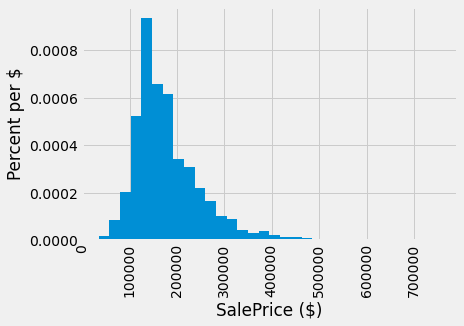

In [10]:
data = sales['SalePrice']
fig, ax = plt.subplots()
n, bins, patches = ax.hist(data, bins=32, density=True)
ax.set_xlabel('SalePrice ($)')
ax.set_ylabel('Percent per $')
ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x,_: f'{(x * 100):.4f}'))
plt.xticks(rotation=90)
plt.show()

#### Correlation

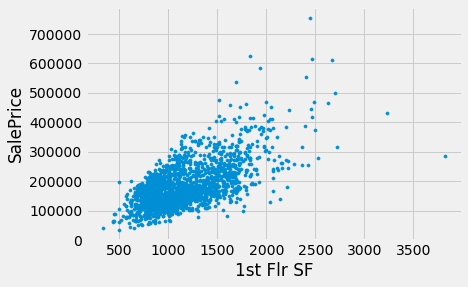

In [12]:
plt.scatter(sales['1st Flr SF'], sales['SalePrice'],  s=10)
plt.xlabel('1st Flr SF')
plt.ylabel('SalePrice')
plt.grid(True)
plt.show()

In [13]:
correlation(sales, 'SalePrice', '1st Flr SF')

0.6424662541030225

In [14]:
for label in sales:
    print('Correlation of', label, 'and SalePrice:\t', correlation(sales, label, 'SalePrice'))

Correlation of SalePrice and SalePrice:	 1.0
Correlation of 1st Flr SF and SalePrice:	 0.6424662541030225
Correlation of 2nd Flr SF and SalePrice:	 0.3575218942800824
Correlation of Total Bsmt SF and SalePrice:	 0.652978626757169
Correlation of Garage Area and SalePrice:	 0.6385944852520443
Correlation of Wood Deck SF and SalePrice:	 0.3526986661950492
Correlation of Open Porch SF and SalePrice:	 0.3369094170263733
Correlation of Lot Area and SalePrice:	 0.2908234551157694
Correlation of Year Built and SalePrice:	 0.5651647537135916
Correlation of Yr Sold and SalePrice:	 0.02594857908072111


In [15]:
both_floors = sales['1st Flr SF'] + sales['2nd Flr SF']
data = sales.copy()
data['Both Floors'] = both_floors
correlation(data, 'SalePrice', 'Both Floors')

0.7821920556134877

## Multiple Linear Regression

In [16]:
train, test = sales.iloc[0:1001,:].reset_index(drop=True), sales.iloc[1001:,:].reset_index(drop=True)
print(train.shape[0], 'training and', test.shape[0], 'test instances.')

1001 training and 1001 test instances.


In [17]:
def predict(slopes, row):
    return sum(slopes * np.array(row))

In [18]:
data = test.copy()
del data['SalePrice']
data.head(1)

,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold
0,672,0,672.0,240.0,168,0,10200,1940,2008


In [19]:
example_row = data.loc[0]
print('Predicting sale price for:\n', example_row)

Predicting sale price for:
 1st Flr SF         672.0
2nd Flr SF           0.0
Total Bsmt SF      672.0
Garage Area        240.0
Wood Deck SF       168.0
Open Porch SF        0.0
Lot Area         10200.0
Year Built        1940.0
Yr Sold           2008.0
Name: 0, dtype: float64


In [20]:
example_slopes = np.random.normal(10, 1, len(example_row))
print('Using slopes:', example_slopes)
print('Result:', predict(example_slopes, example_row))

Using slopes: [ 9.44117161  9.78972435  8.65920524 10.1146813   8.34490826 10.28920489
  9.70100833 11.47258647  8.76757294]
Result: 154805.31055336684


In [21]:
print('Actual sale price:', test['SalePrice'].loc[0])
print('Predicted sale price using random slopes:', predict(example_slopes, example_row))

Actual sale price: 108000
Predicted sale price using random slopes: 154805.31055336684


#### Least Squares Regression

In [22]:
train_prices = train['SalePrice']
train_attributes = train.copy()
del train_attributes['SalePrice']

In [23]:
def rmse(slopes, attributes, prices):
    errors = []
    for i in np.arange(len(prices)):
        predicted = predict(slopes, attributes.loc[i])
        actual = prices[i]
        errors.append((predicted - actual) ** 2)
    return np.mean(errors) ** 0.5

In [24]:
def rmse_train(slopes):
    return rmse(slopes, train_attributes, train_prices)

print('RMSE of all training examples using random slopes:', rmse_train(example_slopes))

RMSE of all training examples using random slopes: 85329.95376221352


In [25]:
best_slopes = minimize(rmse_train, start=example_slopes, smooth=True, array=True)
slopes = pd.DataFrame(columns = train_attributes.columns)
slopes.loc[0] = list(best_slopes)
slopes

,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold
0,72.685742,70.468666,51.194651,55.098065,25.623439,51.7468,0.640872,574.907037,-572.344231


In [26]:
print('RMSE of all training examples using the best slopes:', rmse_train(best_slopes))

RMSE of all training examples using the best slopes: 30804.715196427387


#### Interpreting Multiple Regression 

In [27]:
test_prices = test['SalePrice']
test_attributes = test.copy()
del test_attributes['SalePrice']

In [28]:
def rmse_test(slopes):
    return rmse(slopes, test_attributes, test_prices)

In [29]:
rmse_linear = rmse_test(best_slopes)
print('Test set RMSE for multiple linear regression:', rmse_linear)

Test set RMSE for multiple linear regression: 31776.701802844877


In [36]:
def fit(row):
    return sum(best_slopes * np.array(row))

data = test.copy()
del data['SalePrice']

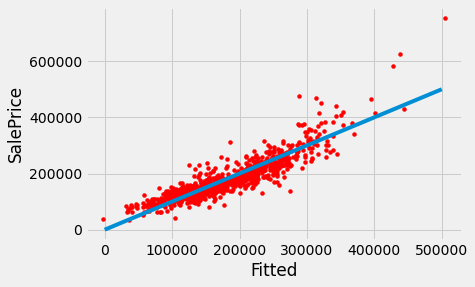

In [37]:
fitted = []
for row in range(data.shape[0]):
    fitted.append(fit(data.loc[row]))
    
data['Fitted'] = fitted
plt.scatter(data['Fitted'], test['SalePrice'], s=15,color='red')
plt.plot([0, 5e5], [0, 5e5]);
plt.xlabel('Fitted')
plt.ylabel('SalePrice')
plt.show()

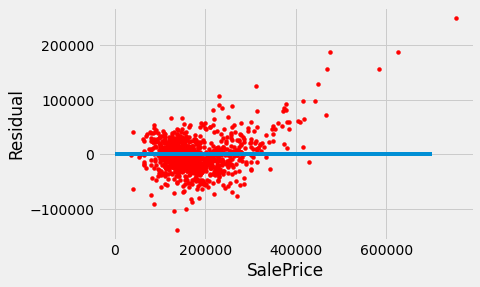

In [38]:
data = test.copy()
temp_data = test.copy()
del temp_data['SalePrice']

fitted = []
for row_number in range(temp_data.shape[0]):
    fitted.append(fit(temp_data.loc[row_number]))

data['Residual'] = test_prices - fitted

plt.scatter(data['SalePrice'], data['Residual'], s=15, color='red')
plt.plot([0, 7e5], [0, 0]);
plt.xlabel('SalePrice')
plt.ylabel('Residual')
plt.show()

## Nearest Neighbors for Regression

In [39]:
train_nn = train.iloc[:,[0, 1, 2, 3, 4, 8]]
train_nn.head(5)

,SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Year Built
0,215000,1656,0,1080.0,528.0,1960
1,105000,896,0,882.0,730.0,1961
2,172000,1329,0,1329.0,312.0,1958
3,244000,2110,0,2110.0,522.0,1968
4,189900,928,701,928.0,482.0,1997


In [40]:
test_nn = test.iloc[:,[0, 1, 2, 3, 4, 8]]
test_nn.head()

,SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Year Built
0,108000,672,0,672.0,240.0,1940
1,152400,864,486,576.0,627.0,1941
2,144000,904,0,864.0,912.0,1970
3,173000,1291,0,1291.0,431.0,1996
4,192000,1156,866,1160.0,505.0,1977


In [41]:
def distance(pt1, pt2):
    """The distance between two points, represented as arrays."""
    return np.sqrt(sum((pt1 - pt2) ** 2))

def row_distance(row1, row2):
    """The distance between two rows of a table."""
    return distance(np.array(row1), np.array(row2))

def distances(training, example, output):
    """Compute the distance from example for each row in training."""
    dists = []
    attributes = training.copy().reset_index(drop=True)
    del attributes[output]
    for row_number in range(len(attributes)):
        dists.append(row_distance(attributes.loc[row_number], example))
    data = training.copy()
    data['Distance'] = dists
    return data

def closest(training, example, k, output):
    """Return a table of the k closest neighbors to example."""
    dists = distances(training, example, output).copy()
    sorted_by_distance = dists.sort_values(by='Distance', ascending=True).reset_index(drop=True)
    topk = sorted_by_distance.head(k)
    return topk

In [42]:
data = test_nn.copy()
del data['SalePrice']
example_nn_row = data.loc[0]
closest(train_nn, example_nn_row, 5, 'SalePrice')

,SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Year Built,Distance
0,113000,672,0,672.0,234.0,1941,6.082763
1,64000,672,0,672.0,256.0,1940,16.000000
2,86900,672,0,672.0,308.0,1940,68.000000
3,118900,732,0,732.0,240.0,1952,85.697141
4,80000,747,0,747.0,220.0,1945,108.050914


In [43]:
def predict_nn(example):
    """Return the majority class among the k nearest neighbors."""
    return np.average(closest(train_nn, example, 5, 'SalePrice')['SalePrice'])

predict_nn(example_nn_row)

92560.0

In [44]:
print('Actual sale price:', test_nn['SalePrice'][0])
print('Predicted sale price using nearest neighbors:', predict_nn(example_nn_row))

Actual sale price: 108000
Predicted sale price using nearest neighbors: 92560.0


#### Evaluation

In [45]:
data = test_nn.copy()
del test_nn['SalePrice']
nn_test_predictions = []
for row_number in range(test_nn.shape[0]):
    nn_test_predictions.append(predict_nn(test_nn.loc[row_number]))
    
rmse_nn = np.mean((test_prices - nn_test_predictions) ** 2) ** 0.5

print('Test set RMSE for multiple linear regression: ', rmse_linear)
print('Test set RMSE for nearest neighbor regression:', rmse_nn)

Test set RMSE for multiple linear regression:  31776.701802844877
Test set RMSE for nearest neighbor regression: 34461.46192940294


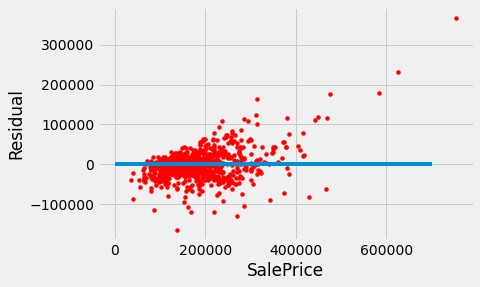

In [48]:
data = test.copy()
data['Residual'] = test_prices - nn_test_predictions
plt.scatter(data['SalePrice'], data['Residual'], s=15, color='red')
plt.plot([0, 7e5], [0, 0]);
plt.xlabel('SalePrice')
plt.ylabel('Residual')
plt.show()

End of Chapter 17


************